<a href="https://colab.research.google.com/github/coldsober-irene/ASSIGNMENTS/blob/main/testDissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install control

In [11]:
import numpy as np
import math
import control
from matplotlib import pyplot as plt

**Plant**

$X(k+1) = Ax(k) + Bu(k)$

$y(k) = Cx(k)$

**Augmented state space**

$$\begin{bmatrix}
\Delta x(k+1) \\\\ y(k+1)
\end {bmatrix}
=
\begin{bmatrix}
A_p & 0_{s*s}\\\\ C_p * A_p & I
\end {bmatrix}
\begin{bmatrix}
\Delta x(k) \\\\ y(k)
\end {bmatrix}
+
\begin{bmatrix}
B_p \\\\ C_p * B_p
\end {bmatrix}
\Delta u(k)$$

#form plant model

In [90]:

class Modeling:
  def __init__(self, H1 = 10, H2 = 12, k1 = 4.3, k2 = 4.7, k3 = 24, area = 32, Np = 10, Nc = 4):
    self.H1 = H1
    self.H2 = H2
    self.k1 = k1
    self.k2 = k2
    self.k3 = k3
    self.area = area
    self.Np = Np
    self.Nc = Nc
    a11 = (-1 / self.area) * ((self.k1 / math.sqrt(self.H1)) + (self.k3 / math.sqrt(abs(self.H1 - self.H2))))
    a12 = (self.k3/ (2*self.area)) * (1 / math.sqrt(abs(self.H1 - self.H2)))
    a21 = (self.k3/ (2*self.area)) * (1 / math.sqrt(abs(self.H1 - self.H2)))
    a22 = (-1 / self.area) * ((self.k2 / math.sqrt(self.H2)) + (self.k3 / math.sqrt(abs(self.H1 - self.H2))))

    self.A_p = np.array([[a11, a12],
                [a21, a22]
                ])
    self.B_p = np.array([[1/self.area, 0],
                [0, 1/self.area]])
    self.C_p = np.eye(2, 2)
    self.D_p = np.zeros((2, 2))

  def discrete(self, Ts = 0.1, method = 'zoh'):
    Ts = 0.1
    # Create a state-space system
    sys_continuous = control.ss(self.A_p, self.B_p, self.C_p, self.D_p)

    # Discretize the system
    sys_discrete = sys_continuous.sample(Ts, method=method)

    Ad = sys_discrete.A
    Bd = sys_discrete.B
    Cd = sys_discrete.C
    Dd = sys_discrete.D
    return Ad, Bd, Cd, Dd

  def augment(self):
    Ad, Bd, Cd, Dd = self.discrete()
    states, _ = Ad.shape
    _, inputs = Bd.shape
    outputs, _ = Cd.shape

    A1 = np.hstack((Ad, np.zeros((states, outputs))))
    A2 = np.hstack((Cd @ Ad, np.eye(outputs, outputs)))
    self.Ae = np.vstack((A1, A2))
    self.Be = np.vstack((Bd,Cd @ Bd))
    self.Ce = np.hstack((np.zeros((outputs, outputs)), np.eye(outputs, outputs)))
    return self.Ae, self.Be, self.Ce

  def mpc_matrices(self):
    global M1, M2, M3
    Ae, Be, Ce = self.augment()
    F = np.empty((Ce @ Ae).shape)
    Phi = []
    phi_dimx, phi_dimy = (Ce @ Ae @ Be).shape

    for i in range(1, self.Np+1):
      F = np.vstack((F, Ce @ (np.linalg.matrix_power(Ae, i))))
      row = []
      for j in range(self.Nc):
        Apower = i - j
        if Apower < 0:
          row.append(np.zeros((phi_dimx, phi_dimy)).tolist())
        else:
          row.append(((Ce @ np.linalg.matrix_power(Ae, Apower)) @ Be).tolist())
      row1 = []
      row2 = []
      for r in row:
        row1.extend(r[0])
        row2.extend(r[1])
      Phi.append(row1)
      Phi.append(row2)

    Phi = np.array(Phi)
    F = F[2:, :]

    # Phi.T @ Phi
    Ref = [self.H1, self.H2]
    Ref = np.array([Ref[0] if (i % 2 == 0) else Ref[1] for i in range(self.Np * 2)])
    M1 = Phi.T @ Phi
    M2 = Phi.T @ F
    M3 = Phi.T @ Ref

  def WithoutConstraint(self, k = 4):
    y = []
    x = []
    u = []
    timestep = []
    Rbar = 0.5
    Ad, Bd, Cd, Dd = self.discrete()
    x_k = np.zeros((2, 1)) # initial
    u_k = np.zeros((2, 1)) # initial

    for i in range(1, k+1):
      x_kp1 = (Ad @ x_k) + (Bd @ u_k)
      Dx_k = x_kp1 - x_k
      y_k = Cd @ x_k
      y.append(y_k)
      x.append(x_kp1)

      x_ki = np.vstack((Dx_k, y_k))
      DU = np.linalg.inv(M1 + (Rbar * np.eye(2*self.Nc))) @ (M3 - (M2 @ x_ki))
      U_trajectory = DU.tolist()
      print("TRAJECTORY: ")
      print("_"*200)
      print("U_K : ", u_k)
      print(np.array(U_trajectory[0][:2]).reshape(2,1))
      print()
      u_k += np.array(U_trajectory[0][:2]).reshape(2, 1) # 1st 2 (one for u1 and 2nd for u2)
      u.append(u_k)
      x_k = x_kp1
      timestep.append(i)
    finalY = []
    finalX = []
    finalU = []
    for arr in y:
      finalY.append(arr.flatten().tolist())
    y = np.array(finalY)

    for arr in x:
      finalX.append(arr.flatten().tolist())
    x = np.array(finalX)

    for arr in u:
      finalU.append(arr.flatten().tolist())
    u = np.array(finalU)

    return y, x, u, timestep

plant = Modeling(Np = 20, Nc = 10, H1 = 15, H2 = 18)
disc = plant.mpc_matrices()
y, x, u, t = plant.WithoutConstraint(k = 300)
# print(disc)

TRAJECTORY: 
________________________________________________________________________________________________________________________________________________________________________________________________________
U_K :  [[0.]
 [0.]]
[[13.87064889]
 [15.95396077]]

TRAJECTORY: 
________________________________________________________________________________________________________________________________________________________________________________________________________
U_K :  [[13.87064889]
 [15.95396077]]
[[13.40678018]
 [15.49009206]]

TRAJECTORY: 
________________________________________________________________________________________________________________________________________________________________________________________________________
U_K :  [[27.27742907]
 [31.44405283]]
[[12.92564627]
 [15.00895815]]

TRAJECTORY: 
_________________________________________________________________________________________________________________________________________________________

In [82]:
U_K = np.array([[0.],[0.]])
p = np.array([13.87064889])
U_K + p

array([[13.87064889],
       [13.87064889]])

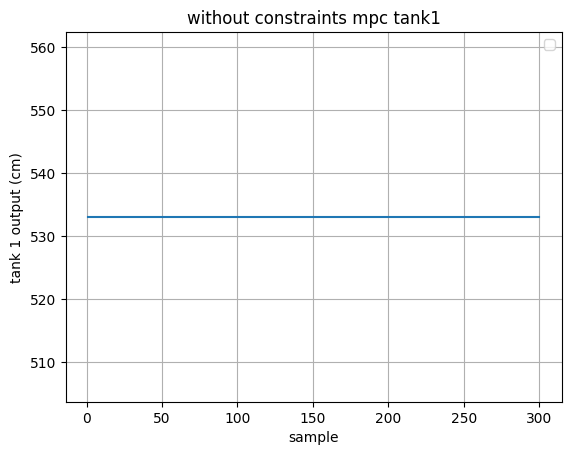

In [89]:
plt.plot(t, u[:, 1])
plt.xlabel("sample")
plt.ylabel("tank 1 output (cm)")
plt.title("without constraints mpc tank1")
plt.legend()
# plt.plot(t, y[:, 1], marker = '+')
plt.grid(True)
plt.show()
# print("2nd:: ", y[:, 1])


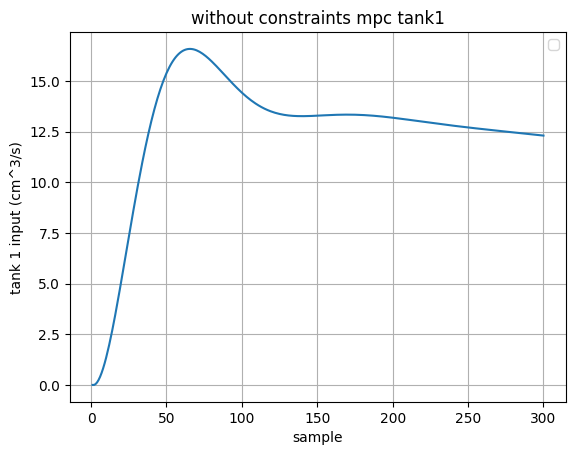

In [86]:
plt.plot(t, y[:, 0])
plt.xlabel("sample")
plt.ylabel("tank 1 input (cm^3/s)")
plt.title("without constraints mpc tank1")
plt.legend()
# plt.plot(t, y[:, 1], marker = '+')
plt.grid(True)
plt.show()

In [68]:
x = np.array([[2], [7]])
x.T.shape, x.shape


((1, 2), (2, 1))

In [70]:
a = np.array([[1, 2],[3, 4]])
b = np.array([[-1], [4]])
a @ b

array([[ 7],
       [13]])